루브릭 1-1. 사진1 - 아웃포커싱 효과가 적용된 본인의 인물모드 사진

(1) 데이터 준비 - 사진

In [1]:
import os
import urllib # 웹에서 데이터를 다운로드하기
import cv2 # OpenCV 라이브러리로 이미지를 처리
import numpy as np
from pixellib.semantic import semantic_segmentation # 시맨틱 세그멘테이션 모델을 편하게 사용할 수 있는 라이브러리
from matplotlib import pyplot as plt

print('슝=3')

슝=3


(1080, 1441, 3)


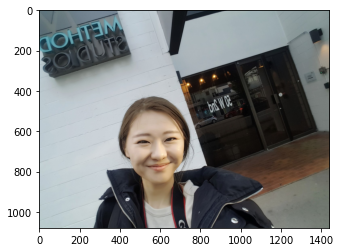

In [2]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

(2) 사람 분리하기 ft. 세그멘테이션(=누끼)
사용 모델 - DeepLab 알고리즘(DeepLab v3+)


In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f5cec0ef310>)

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path) 
# segvalues에는 class_ids와 masks가 있다. class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있다. 
# output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨있다.

# PASCAL VOC 데이터로 학습된 모델 
# 모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요.

In [6]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

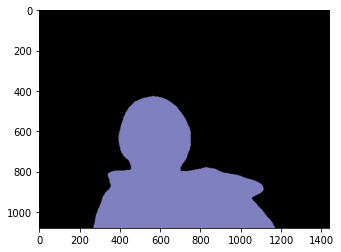

In [7]:
# 사람만 검출하고 싶다 -> 사람(person) 라벨, 즉 15를 가진 영역만 검출
plt.imshow(output)
plt.show()

In [8]:
segvalues
# segvalues에는 class_ids와 masks가 있음. 

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
# 그래서 아래 class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있음
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [10]:
# 이제 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내면 됨

# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 색상 코드 결과물이예요!

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
#  이 중에서 우리가 원하는 것은 사람을 나타내는 15번째의 색상
colormap[15]

array([192, 128, 128])

In [12]:
# 여기서 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있음(openCV)
# but colormap은 RGB 순서
# 따라서 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔주어야 함
seg_color = (128,128,192)

(1080, 1441)


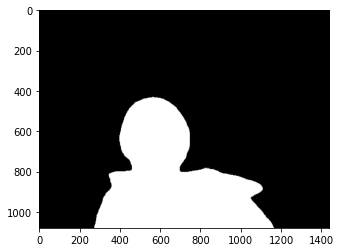

In [13]:
# 이제 seg_color로만 이루어진 마스크*를 만들어보자.
# *3채널 가졌던 원본과는 다르게 채널 정보가 사라짐
# *물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열

# 아래 코드는 output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

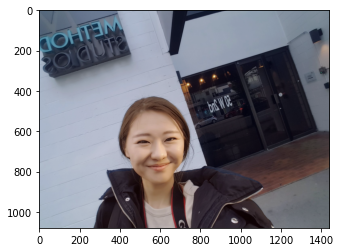

In [14]:
# 세그멘테이션이 얼마나 잘 되었는지 보기 위해 원래 이미지와 겹쳐보자.


img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.9, color_mask, 0.1, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

(4) 배경 흐리게 하기 - blur() 함수

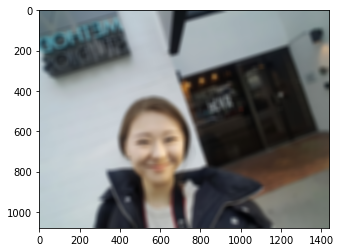

In [15]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (26,26))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

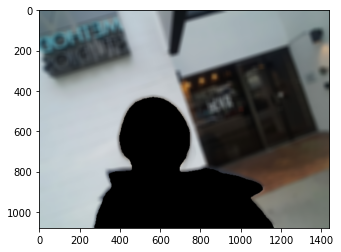

In [16]:
# 흐려진 이미지에서 배경만 추출하기 - 세그멘테이션 마스크 이용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()
# 이미지 반전 - bitwise_not 함수 
# ex. 원래 마스크에서는 배경이 0, 사람이 255 -> bitwise_not 연산 -> 배경 255, 사람 0 -> 결국 사람이 사라짐

(5) 흐린 배경과 원본 합성

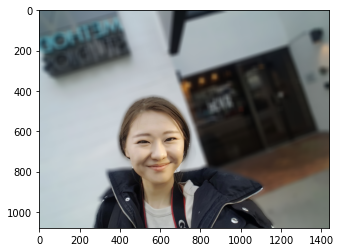

In [17]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) 
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가져오기
# 세그멘테이션 마스크가 255가 아닌 부분은 아닌 영역은 블러된 이미지 값을 사용

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

# matplotlib.pyplot 이미지 저장하기 - plt.figure('저장하고자 하는 파일명.확장자')
# plt.savefig('my_image_saved.png', dpi=300)

plt.show()

1-2. 아웃포커싱 효과가 적용된 고양이 사진

(586, 599, 3)


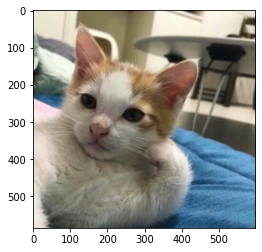

In [18]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image2.png'  
img_orig2 = cv2.imread(img_path) 

print(img_orig2.shape)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))            
plt.show()

In [19]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f5c813db400>)

In [20]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [21]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path) 
# segvalues에는 class_ids와 masks가 있다. class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있다. 
# output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨있다.

# PASCAL VOC 데이터로 학습된 모델 
# 모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요.

In [22]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

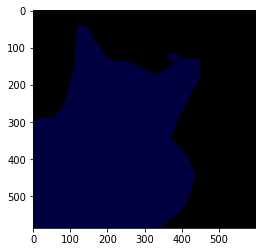

In [23]:
plt.imshow(output)
plt.show()

In [24]:
segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [25]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [26]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [27]:
colormap[8]

array([64,  0,  0])

In [28]:
seg_color = (0,0,64)

(586, 599)


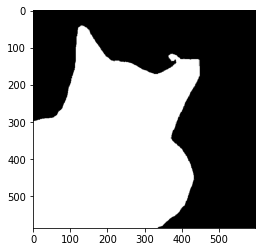

In [29]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

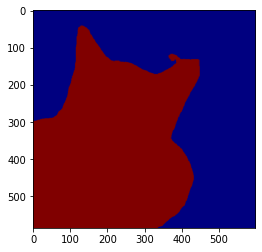

In [30]:
img_show = img_orig2.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask2 = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.0001, color_mask2, 0.9999, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

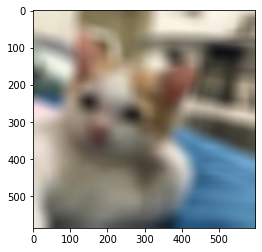

In [31]:
img_orig_blur2 = cv2.blur(img_orig2, (39,39))  
plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))
plt.show()

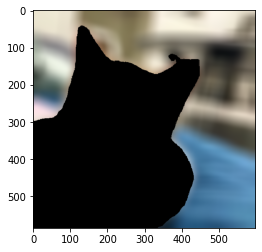

In [32]:
img_mask_color2 = cv2.cvtColor(img_mask2, cv2.COLOR_GRAY2BGR)
img_bg_mask2 = cv2.bitwise_not(img_mask_color2)
img_bg_blur2 = cv2.bitwise_and(img_orig_blur2, img_bg_mask2)
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()

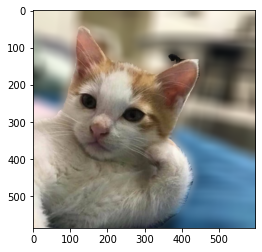

In [33]:
img_concat2 = np.where(img_mask_color2==255, img_orig2, img_bg_blur2) 
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가져오기
# 세그멘테이션 마스크가 255가 아닌 부분은 아닌 영역은 블러된 이미지 값을 사용

plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

1-3. 배경전환 크로마키사진

(1080, 1441, 3)


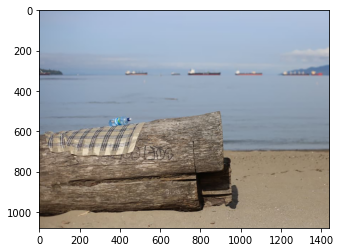

In [34]:
# 배경 가져오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/img_bg_new.png'  
img_bg_new = cv2.imread(img_path) 

print(img_bg_new.shape)
plt.imshow(cv2.cvtColor(img_bg_new, cv2.COLOR_BGR2RGB))
plt.show()

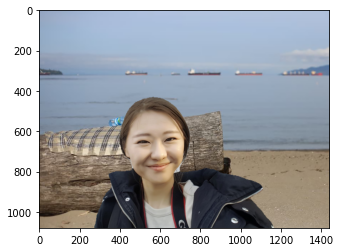

In [35]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_new) 
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가져오기
# 세그멘테이션 마스크가 255가 아닌 부분은 아닌 영역은 블러된 이미지 값을 사용

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

루브릭 2-1. 인물모드 사진에서 발생된 문제점 찾기

(448, 800, 3)


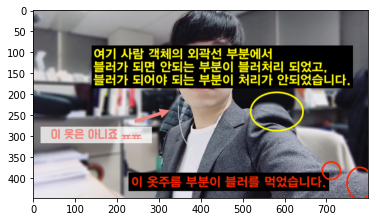

In [36]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/step2.png'  
img_orig3 = cv2.imread(img_path) 

print(img_orig3.shape)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

2-2. 인물모드 사진2에서 발생된 문제점 찾기

(901, 1205, 3)


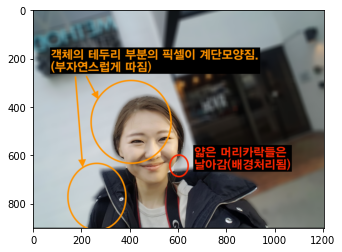

In [37]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/step2_2.png'  
img_orig4 = cv2.imread(img_path) 

print(img_orig4.shape)
plt.imshow(cv2.cvtColor(img_orig4, cv2.COLOR_BGR2RGB))
plt.show()

2. 제작한 인물모드 사진들에서 나타나는 문제점 - 사진2. 배경 중 진한 그림자 부분이 거릿값이 가까운 것으로 판단되었기 때문인지?? 고양이 객체로 분류됨

3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션 - 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시 

지금 당장은 파이썬 공부가 시급하여... (ㅠㅠ) 마지막 문제는 기권합니다....